code: https://github.com/ritts97/Unsupervised-Face-Clustering

## Setup

In [1]:
import sys
import os
import dlib
import glob
import time

import cv2
import os

import matplotlib.pyplot as plt

from face_classifier import FaceClassifier

import random
import torch
import numpy as np

import calc
import icio
import postproc

from person_db import Person
from person_db import Face
from person_db import PersonDB

print(dlib.DLIB_USE_CUDA)
print(cv2.__version__)

/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


True
4.5.5


In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False  # type: ignore

seed_everything(79)

In [3]:
import face_recognition

def check_use_gpu(TARGET_IMG_PATH):
    image = face_recognition.load_image_file(TARGET_IMG_PATH)
    face_locations = face_recognition.face_locations(image,model='cnn')
    if len(face_locations) > 0:
        print('Using GPU')
    else:
        print('***Not using GPU***')

TARGET_IMG_PATH = "/opt/ml/project/test_videos/dongmin_before_15m_result_images_face_cloth/20220526_063429.551-0.png"
check_use_gpu(TARGET_IMG_PATH)

Using GPU


## Extract frame from video and save as images

In [4]:
video_paths = {
    0: "/opt/ml/project/test_videos/leejung_rain_before_14m.mp4",
    1: "/opt/ml/project/test_videos/giha_before_13m.mp4",
    2: "/opt/ml/project/test_videos/dongmin_before_15m.mp4",
    3: "/opt/ml/project/test_videos/KakaoTalk_20220526_162306287.mp4",
    4: "/opt/ml/project/test_videos/KakaoTalk_20220526_162432101.mp4",
    5: "/opt/ml/project/test_videos/KakaoTalk_20220526_162549989.mp4",
}

In [5]:
file_num = 0

filepath = video_paths[file_num]
video = cv2.VideoCapture(filepath)

assert video.isOpened(), f"Could not Open : {filepath}"

In [6]:
# 불러온 비디오 파일의 정보 출력
length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = video.get(cv2.CAP_PROP_FPS)

print("length :", length)
print("width :", width)
print("height :", height)
print("fps :", fps)

length : 25562
width : 1280
height : 720
fps : 29.97002997002997


In [7]:
# 변수 설정
frame_batch_size = 16
capture_interval = 3 * int(round(fps)) # n초 간격 프레임 캡쳐
stop = 300 # 0 초과의 정수 지정 시 n 초 까지만 영상 실행
skip = 0 # 초반 n 초 skip
face_cnt = 150 # 몇 장의 인물 사진을 사용할 지
capture_cnt = 60
threshold = 0.36 # 같은 인물로 판단할 threshold -> 낮을수록 같은 인물로 판단하지 않음
ratio = 1.0 # resizing ratio인데, 건드리지 않는게 좋을 듯

In [8]:
result_dir = filepath[:-4] + '_result_images_face_cloth_pytorch_resnet18'
# pdb = PersonDB()
# pdb.load_db(result_dir)
# pdb.print_persons()

In [9]:
try:
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
except OSError:
    print('Error: Creaing directory. ' + result_dir)

**dnn_superres 사용**
```
pip uninstall opencv-python
pip uninstall opencv-contrib-python
pip3 install opencv-contrib-python
```
- 코드 및 성능비교표: https://learnopencv.com/super-resolution-in-opencv/ 
- super resolution 모델들 & 다운로드 링크: https://github.com/opencv/opencv_contrib/blob/master/modules/dnn_superres/README.md

In [10]:
video = cv2.VideoCapture(filepath) 

# FaceClssifier 인스턴스 생성
fc = FaceClassifier(threshold, ratio, result_dir)

fingerprints = dict()

frames = []
frame_count = 0
cnt = 0

running = True

start = time.time()
while running:
    ret, frame = video.read()

    if frame is None:
        break

    seconds = int(round(frame_count / fps, 3))
    # print(f"Running in {seconds} sec in video...")
    if seconds > stop > 0:
        break
    if seconds < skip:
        continue
    if frame_count % capture_interval == 0:
        frames.append(frame)

    if len(frames) == frame_batch_size:
        # 얼굴 디텍션 -> 얼굴 인코딩(frame, face_boxes) -> 옷 디텍션 -> 옷 인코딩(read_frames 코드 + _frame_worker 코드 + get_model 코드 + fingerprint 코드) -> 이미지 저장
        # 반환: 상체 이미지(파일명): [얼굴 인코딩 | 옷 인코딩] (fingerprint)
        frame_fingerprints = fc.detect_faces(frames,frame_batch_size)
        if frame_fingerprints:
            fingerprints.update(frame_fingerprints)
            print('Face images: ', len(fingerprints))
            cnt += 1
            print('frame_cnt: ', cnt)
            print()
        
        frames = []
        
    if cnt >= capture_cnt:
        break
    
    frame_count += 1



# restore SIGINT (^C) handler
running = False
video.release()
print()

# pdb.save_db(result_dir)
# pdb.print_persons()

end = time.time()
print('Inference time: ',end-start)
print("Captured frames : ", frame_count)

image saved path:  /opt/ml/project/test_videos/leejung_rain_before_14m_result_images_face_cloth_pytorch_resnet18/20220529_134659.761-0.png
image saved path:  /opt/ml/project/test_videos/leejung_rain_before_14m_result_images_face_cloth_pytorch_resnet18/20220529_134659.761-1.png
image saved path:  /opt/ml/project/test_videos/leejung_rain_before_14m_result_images_face_cloth_pytorch_resnet18/20220529_134659.797-0.png
image saved path:  /opt/ml/project/test_videos/leejung_rain_before_14m_result_images_face_cloth_pytorch_resnet18/20220529_134659.797-1.png
image saved path:  /opt/ml/project/test_videos/leejung_rain_before_14m_result_images_face_cloth_pytorch_resnet18/20220529_134659.836-0.png
image saved path:  /opt/ml/project/test_videos/leejung_rain_before_14m_result_images_face_cloth_pytorch_resnet18/20220529_134659.836-1.png
image saved path:  /opt/ml/project/test_videos/leejung_rain_before_14m_result_images_face_cloth_pytorch_resnet18/20220529_134659.874-0.png
image saved path:  /opt/ml/

In [11]:
# video = cv2.VideoCapture(filepath) 

# # FaceClssifier 인스턴스 생성
# fc = FaceClassifier(threshold, ratio, result_dir)

# fingerprints = dict()

# frames = []
# frame_id = 0
# cnt = 0

# total_start_time = time.time()

# while running:
#     ret, frame = video.read()
    
#     if frame is None:
#         break

#     frame_id += 1
#     if frame_id % capture_interval != 0:
#         continue

#     seconds = int(round(frame_id / fps, 3))
#     print(f"Running in {seconds} sec in video...")
#     if seconds > stop > 0:
#         break
#     if seconds < skip:
#         continue

#     frames.append(frame)
#     # if frame_id % capture_interval == 0:
#     #     frames.append(frame)

#     if len(frames) == frame_batch_size:
#         # 얼굴 디텍션 -> 얼굴 인코딩(frame, face_boxes) -> 옷 디텍션 -> 옷 인코딩(read_frames 코드 + _frame_worker 코드 + get_model 코드 + fingerprint 코드) -> 이미지 저장
#         # 반환: 상체 이미지(파일명): [얼굴 인코딩 | 옷 인코딩] (fingerprint)
#         frame_fingerprints = fc.detect_faces(frames, frame_batch_size)

#         print('frame_fingerprints', frame_fingerprints)

#         if frame_fingerprints:
#             fingerprints.update(frame_fingerprints)
#             print('Face images: ', len(fingerprints))
#             print('frame_cnt: ', frame_id)
#             print()
            
#         frames = []

#     if len(fingerprints) >= face_cnt:
#         break



# # restore SIGINT (^C) handler
# running = False
# video.release()
# total_elapsed_time = time.time() - total_start_time

# print()
# print("Inference time : %.3f second" % total_elapsed_time)
# print('Captured frame : ', frame_id)

# # pdb.save_db(result_dir)
# # pdb.print_persons()

In [12]:
filepath = video_paths[file_num]
result_dir = filepath[:-4] + '_result_images_face_cloth_pytorch_resnet18'

In [13]:
print(fingerprints)

{'/opt/ml/project/test_videos/leejung_rain_before_14m_result_images_face_cloth_pytorch_resnet18/20220529_134659.761-0.png': array([-0.06895816,  0.04206265,  0.05383516, -0.05371757, -0.06811888,
       -0.0082409 , -0.05842949, -0.09227769,  0.13284765, -0.10157627,
        0.15866391, -0.05576387, -0.1274807 , -0.02036199, -0.03627654,
        0.12780277, -0.10227887, -0.13827344, -0.00367446, -0.00880005,
        0.01291617,  0.02080632, -0.02332003,  0.03664633, -0.12857503,
       -0.21491363, -0.07445427, -0.08035563, -0.01248426, -0.08427688,
        0.00224991,  0.0777285 , -0.14461023,  0.00677906, -0.00525593,
        0.06306815,  0.04099747, -0.03864238,  0.09193167,  0.0140338 ,
       -0.21248879, -0.02144006,  0.05496513,  0.19238057,  0.10392682,
       -0.02864505, -0.0136864 , -0.05174842,  0.04916519, -0.11988251,
       -0.01750345,  0.07444024,  0.08008855,  0.03478435, -0.01904185,
       -0.11581831,  0.01852304,  0.04697189, -0.10526198,  0.03206247,
        0.06

#images : #clusters
3 : 2
5 : 1
12 : 1
#images in clusters total:  23
cluster dir: /opt/ml/project/test_videos/leejung_rain_before_14m_result_images_face_cloth_pytorch_resnet18/imagecluster/clusters
/opt/ml/project/test_videos/leejung_rain_before_14m_result_images_face_cloth_pytorch_resnet18/20220529_134702.758-1.png/opt/ml/project/test_videos/leejung_rain_before_14m_result_images_face_cloth_pytorch_resnet18/20220529_134707.859-0.png/opt/ml/project/test_videos/leejung_rain_before_14m_result_images_face_cloth_pytorch_resnet18/20220529_134710.909-2.png/opt/ml/project/test_videos/leejung_rain_before_14m_result_images_face_cloth_pytorch_resnet18/20220529_134713.501-1.png/opt/ml/project/test_videos/leejung_rain_before_14m_result_images_face_cloth_pytorch_resnet18/20220529_134708.031-2.png/opt/ml/project/test_videos/leejung_rain_before_14m_result_images_face_cloth_pytorch_resnet18/20220529_134713.413-0.png/opt/ml/project/test_videos/leejung_rain_before_14m_result_images_face_cloth_pytorch_re

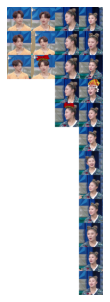

In [17]:
# 클러스터링(fingerprints) 후 결과 출력
clusters = calc.cluster(fingerprints, sim=0.72, method='single', min_csize=3) # 높일수록 엄격하게

postproc.make_links(clusters, os.path.join(result_dir, 'imagecluster/clusters'))

images = icio.read_images(result_dir, size=(224,224))

fig, ax = postproc.plot_clusters(clusters, images)
fig.savefig(os.path.join(result_dir, 'imagecluster/_cluster.png'))
postproc.plt.show()